In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from datasets import FillDataset

import torch
import torch.nn as nn
import logging


from diffusers import SD3Transformer2DModel, AutoencoderKL

from transformers import CLIPTextModelWithProjection, CLIPTokenizer, T5EncoderModel, T5TokenizerFast
from text_embed import encode_prompt

2024-11-13 17:02:50.062869: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 17:02:50.062919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 17:02:50.064006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 17:02:50.069666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-13 17:02:50.777751: W tensorflow/compiler/tf2

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


  0%|          | 0/28 [00:00<?, ?it/s]

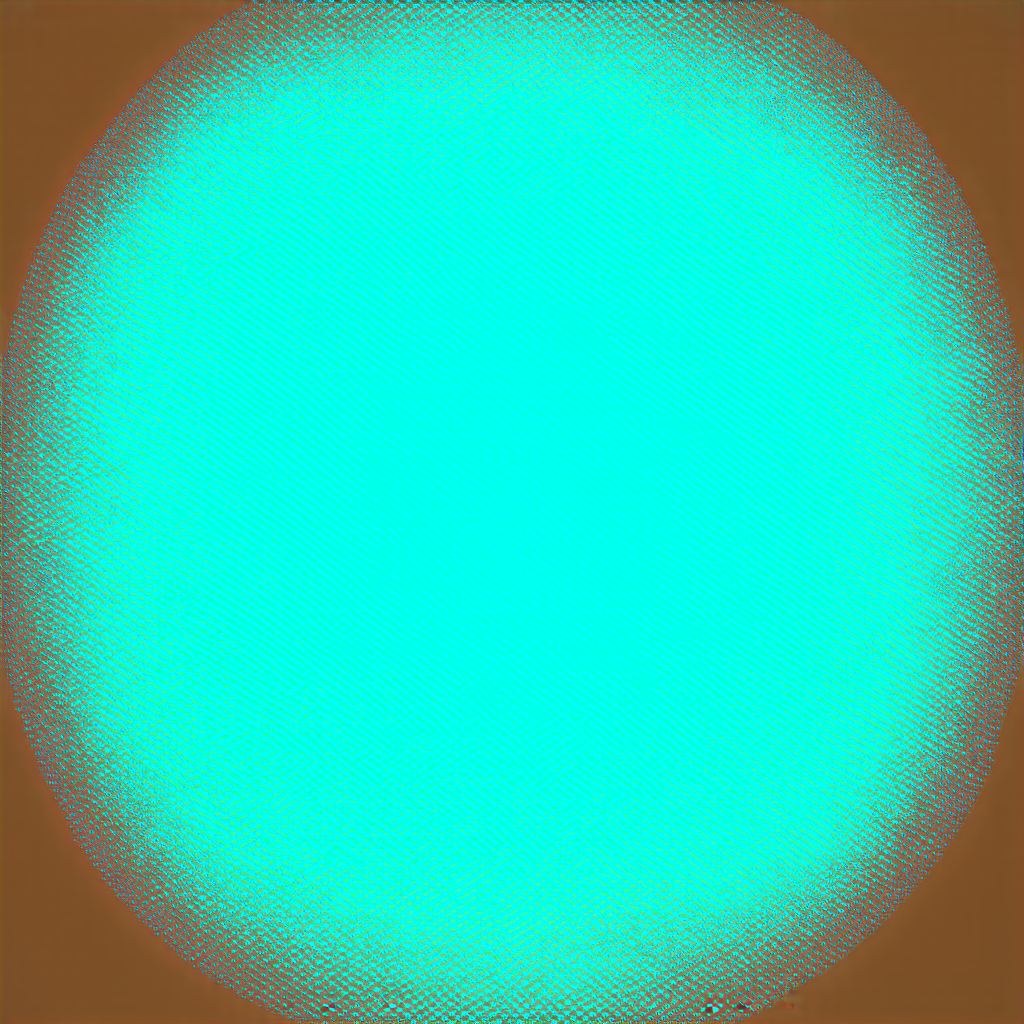

In [3]:
import torch
from diffusers import StableDiffusion3Pipeline

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

image = pipe(
    "Cyan circle with brown background",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
).images[0]
image

In [2]:
dataset = FillDataset()
print(len(dataset))

item = dataset[0]
jpg = item['jpg']
txt = item['txt']
hint = item['hint']
print(txt)
print(jpg.shape)
print(hint.shape)

NameError: name 'FillDataset' is not defined

In [1]:
jpg

NameError: name 'jpg' is not defined

In [69]:
transformer = SD3Transformer2DModel.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    subfolder="transformer",
    torch_dtype=torch.float16,
).to('cuda:1')

vae = AutoencoderKL.from_pretrained(
            "stabilityai/stable-diffusion-3-medium",
            subfolder="vae",
            revision="refs/pr/26",
    ).to('cuda:1')

In [13]:
text_model1 = "openai/clip-vit-large-patch14"
tokenizer1 = CLIPTokenizer.from_pretrained(text_model1)
text_encoder1 = CLIPTextModelWithProjection.from_pretrained(text_model1)

text_model2 = "laion/CLIP-ViT-bigG-14-laion2B-39B-b160k"
tokenizer2 = CLIPTokenizer.from_pretrained(text_model2)
text_encoder2 = CLIPTextModelWithProjection.from_pretrained(text_model2)

text_model3 = "google/t5-v1_1-xxl"
tokenizer3 = T5TokenizerFast.from_pretrained(text_model3)
text_encoder3 = T5EncoderModel.from_pretrained(text_model3)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
prompt_list = [dataset[0]["txt"], dataset[1]["txt"]]
img_list = [dataset[0]["jpg"], dataset[1]["jpg"]]
hint_list = [dataset[0]["hint"], dataset[1]["hint"]]

In [15]:
encoder_list = [text_encoder1, text_encoder2, text_encoder3]
tokenizer_list = [tokenizer1, tokenizer2, tokenizer3]

In [16]:
for encoder in encoder_list:
    for param in encoder.parameters():
        param.requires_grad = False

In [18]:
prompt_embeds1, pooled_prompt_embeds1 = encode_prompt(encoder_list, tokenizer_list, dataset[0]['txt'], 77)
prompt_embeds2, pooled_prompt_embeds2 = encode_prompt(encoder_list, tokenizer_list, dataset[1]['txt'], 77)


In [1]:
device = 'cuda:1'

In [20]:
tensor_list = [
    {'prompt_embeds': prompt_embeds1, 
     'pooled_prompt_embeds': pooled_prompt_embeds1,
     'prompt': prompt_list[0], 
     'img': img_list[0],
     'hint': hint_list[0]
    },
    {'prompt_embeds': prompt_embeds2, 
     'pooled_prompt_embeds': pooled_prompt_embeds2,
     'prompt': prompt_list[1], 
     'img': img_list[1],
     'hint': hint_list[1]
    }
]
torch.save(tensor_list, 'prompt_tensors_list.pt')

In [2]:
tensor_list = torch.load('prompt_tensors_list.pt')

NameError: name 'torch' is not defined

In [3]:
from diffusers import FlowMatchEulerDiscreteScheduler

In [4]:
noise_scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers", subfolder="scheduler"
)

In [25]:
import copy

In [26]:
noise_scheduler_copy = copy.deepcopy(noise_scheduler)

In [57]:
tensor_list = torch.load('prompt_tensors_list.pt')
for data in tensor_list:
    for key in ['img', 'hint']:
        data[key] = torch.tensor(data[key]).permute(2, 0, 1).unsqueeze(dim=0).to(device)

In [58]:
pixel_values = tensor_list[0]['img']
hint_values = tensor_list[0]['img']

In [59]:
hint_values.shape

torch.Size([1, 3, 512, 512])

In [17]:
pixel_values.shape

torch.Size([1, 3, 512, 512])

In [18]:
model_input = vae.encode(pixel_values).latent_dist.sample()
model_input = (model_input - vae.config.shift_factor) * vae.config.scaling_factor

In [34]:
model_input = model_input.to(device)

In [52]:
vae.config.shift_factor

0.0609

In [1]:
from diffusers.training_utils import compute_density_for_timestep_sampling, compute_loss_weighting_for_sd3, free_memory

2024-10-31 09:05:44.982174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-31 09:05:44.982224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-31 09:05:44.983174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-31 09:05:44.989455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 09:05:45.823735: W tensorflow/compiler/tf2

In [3]:
import torch

In [19]:
# Sample noise that we'll add to the latents
noise = torch.randn_like(model_input)
bsz = model_input.shape[0]
# Sample a random timestep for each image
# for weighting schemes where we sample timesteps non-uniformly
u = compute_density_for_timestep_sampling(
    weighting_scheme="logit_normal",
    batch_size=1,
    logit_mean=0,
    logit_std=1,
    mode_scale=1.29,
)

In [36]:
noise = noise.to('cuda')

In [32]:
model_input.device

device(type='cpu')

In [37]:
indices = (u * noise_scheduler_copy.config.num_train_timesteps).long()
timesteps = noise_scheduler_copy.timesteps[indices].to(device=model_input.device)

# Add noise according to flow matching.
# zt = (1 - texp) * x + texp * z1
sigmas = get_sigmas(timesteps, n_dim=model_input.ndim, dtype=model_input.dtype)
noisy_model_input = (1.0 - sigmas) * model_input + sigmas * noise

In [39]:
noisy_model_input.shape

torch.Size([1, 16, 64, 64])

In [66]:
hint_values

tensor([[[[0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          ...,
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
          [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843]],

         [[0.9216, 0.9216, 0.9216,  ..., 0.9216, 0.9216, 0.9216],
          [0.9216, 0.9216, 0.9216,  ..., 0.9216, 0.9216, 0.9216],
          [0.9216, 0.9216, 0.9216,  ..., 0.9216, 0.9216, 0.9216],
          ...,
          [0.9216, 0.9216, 0.9216,  ..., 0.9216, 0.9216, 0.9216],
          [0.9216, 0.9216, 0.9216,  ..., 0.9216, 0.9216, 0.9216],
          [0.9216, 0.9216, 0.9216,  ..., 0.9216, 0.9216, 0.9216]],

         [[0.8039, 0.8039, 0.8039,  ..., 0.8039, 0.8039, 0.8039],
          [0.8039, 0.8039, 0.8039,  ..., 0.8039, 0.8039, 0.8039],
          [0.8039, 0.8039, 0.8039,  ..., 0

In [70]:
vae.encode(hint_values)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument weight in method wrapper_CUDA__cudnn_convolution)

In [67]:
vae.config.shift_factor

0.0609

In [65]:
hint_input = vae.encode(hint_values).latent_dist.sample()
hint_input = (hint_input - vae.config.shift_factor) * vae.config.scaling_factor

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [53]:
control_next_model = ControlNeXtModel().to('cuda')

In [61]:
res = control_next_model(hint_values, timesteps)

In [63]:
res['output'].shape

torch.Size([1, 320, 64, 64])

In [41]:
from typing import Any, Dict, List, Optional, Tuple, Union

import torch
from torch import nn

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.models.embeddings import TimestepEmbedding, Timesteps
from diffusers.models.modeling_utils import ModelMixin
from diffusers.models.resnet import Downsample2D, ResnetBlock2D
    

class ControlNeXtModel(ModelMixin, ConfigMixin):
    _supports_gradient_checkpointing = True

    @register_to_config
    def __init__(
        self,
        time_embed_dim = 256,
        in_channels = [128, 128],
        out_channels = [128, 256],
        groups = [4, 8],
        controlnext_scale=1.
    ):
        super().__init__()

        self.time_proj = Timesteps(128, True, downscale_freq_shift=0)
        self.time_embedding = TimestepEmbedding(128, time_embed_dim)
        self.embedding = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(2, 64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(2, 64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(2, 128),
            nn.ReLU(),
        )

        self.down_res = nn.ModuleList()
        self.down_sample = nn.ModuleList()
        for i in range(len(in_channels)):
            self.down_res.append(
                ResnetBlock2D(
                    in_channels=in_channels[i],
                    out_channels=out_channels[i],
                    temb_channels=time_embed_dim,
                    groups=groups[i]
                ),
            )
            self.down_sample.append(
                Downsample2D(
                    out_channels[i],
                    use_conv=True,
                    out_channels=out_channels[i],
                    padding=1,
                    name="op",
                )
            )
        
        self.mid_convs = nn.ModuleList()
        self.mid_convs.append(nn.Sequential(
            nn.Conv2d(
                in_channels=out_channels[-1],
                out_channels=out_channels[-1],
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.GroupNorm(8, out_channels[-1]),
            nn.Conv2d(
                in_channels=out_channels[-1],
                out_channels=out_channels[-1],
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.GroupNorm(8, out_channels[-1]),
        ))
        self.mid_convs.append(
            nn.Conv2d(
            in_channels=out_channels[-1],
            out_channels=320,
            kernel_size=1,
            stride=1,
        ))

        self.scale = controlnext_scale

    def forward(
        self,
        sample: torch.FloatTensor,
        timestep: Union[torch.Tensor, float, int],
    ):
        
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            # This would be a good case for the `match` statement (Python 3.10+)
            is_mps = sample.device.type == "mps"
            if isinstance(timestep, float):
                dtype = torch.float32 if is_mps else torch.float64
            else:
                dtype = torch.int32 if is_mps else torch.int64
            timesteps = torch.tensor([timesteps], dtype=dtype, device=sample.device)
        elif len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        batch_size = sample.shape[0]
        timesteps = timesteps.expand(batch_size)

        t_emb = self.time_proj(timesteps)

        # `Timesteps` does not contain any weights and will always return f32 tensors
        # but time_embedding might actually be running in fp16. so we need to cast here.
        # there might be better ways to encapsulate this.
        t_emb = t_emb.to(dtype=sample.dtype)

        emb = self.time_embedding(t_emb)

        sample = self.embedding(sample)

        for res, downsample in zip(self.down_res, self.down_sample):
            sample = res(sample, emb)
            sample = downsample(sample, emb)
        
        sample = self.mid_convs[0](sample) + sample
        sample = self.mid_convs[1](sample)
        
        return {
            'output': sample,
            'scale': self.scale,
        }
    

In [40]:
model_input.shape

torch.Size([1, 16, 64, 64])

In [30]:
def get_sigmas(timesteps, n_dim=4, dtype=torch.float32, device="cuda"):
    sigmas = noise_scheduler_copy.sigmas.to(device=device, dtype=dtype)
    schedule_timesteps = noise_scheduler_copy.timesteps.to(device)
    # timesteps = timesteps.to(accelerator.device)
    step_indices = [(schedule_timesteps == t).nonzero().item() for t in timesteps]

    sigma = sigmas[step_indices].flatten()
    while len(sigma.shape) < n_dim:
        sigma = sigma.unsqueeze(-1)
    return sigma

In [22]:
noise.shape

torch.Size([1, 16, 64, 64])

In [20]:
u

tensor([0.5920])

In [50]:
model_input

tensor([[[[ 0.5711,  0.6163,  0.5436,  ...,  0.5670,  0.5639,  0.7948],
          [ 0.6272,  0.5906,  0.5291,  ...,  0.5508,  0.5644,  0.5648],
          [ 0.6847,  0.5709,  0.5189,  ...,  0.5013,  0.4719,  0.5047],
          ...,
          [ 0.6466,  0.5639,  0.5026,  ...,  0.5060,  0.4690,  0.5258],
          [ 0.7154,  0.6707,  0.5415,  ...,  0.5292,  0.5381,  0.6407],
          [ 0.5723,  0.3418,  0.3065,  ...,  0.3226,  0.3396,  0.2554]],

         [[-0.3030, -0.6567, -0.7042,  ..., -0.7500, -0.7010, -0.2314],
          [-0.1118, -0.4534, -0.5227,  ..., -0.5604, -0.5018, -0.3567],
          [-0.2342, -0.5176, -0.5859,  ..., -0.6250, -0.5460, -0.4082],
          ...,
          [-0.2341, -0.5109, -0.5464,  ..., -0.5850, -0.5115, -0.3681],
          [-0.2872, -0.4887, -0.5481,  ..., -0.5756, -0.4824, -0.3423],
          [-0.2067, -0.3374, -0.4073,  ..., -0.4105, -0.3632, -0.0780]],

         [[ 0.7046,  0.7955,  0.7596,  ...,  0.7929,  0.8339,  1.0197],
          [ 0.7299,  0.6098,  

In [49]:
model_input.shape

torch.Size([1, 16, 64, 64])